In [1]:
!rm -rf pytorch_utils
!git clone https://github.com/toniqapps/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 106 (delta 61), reused 36 (delta 14), pack-reused 0
Receiving objects: 100% (106/106), 28.07 KiB | 14.04 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==0.4.6 is successfully installed


In [3]:
import numpy as np
import pickle
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib

import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
from pytorch_utils import dataset
train, test = dataset.cifar10_albumentations()

Data has apparently already been downloaded and unpacked.
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_5
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/test_batch


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


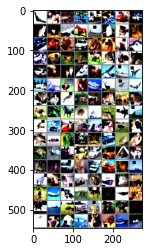

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [9]:
from torchsummary import summary
from pytorch_utils import models

net = models.CIFAR10_RESNET_S8(models.BasicBlock, [2, 2, 2, 2]).to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [20]:
import torch.optim as optim
from pytorch_utils import train, test
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

model_name = 'cifar_10_plot'

train_losses = dict()
train_acc = dict()
test_losses = dict()
test_acc = dict()

train_losses[model_name] = []
train_acc[model_name] = []
test_losses[model_name] = []
test_acc[model_name] = []


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_loss, tr_acc = train.train(net, device, trainloader, optimizer, criterion, epoch, [], dict())
    train_losses[model_name].extend(tr_loss)
    train_acc[model_name].extend(tr_acc)
    te_loss, te_acc = test.test(net, device, testloader, criterion)
    test_losses[model_name].extend(te_loss)
    test_acc[model_name].extend(te_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.5423252582550049 Batch_id=390 Accuracy=33.05: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 2122/5000 (42.44%)

EPOCH: 1


Loss=1.2163183689117432 Batch_id=390 Accuracy=51.41: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 2742/5000 (54.84%)

EPOCH: 2


Loss=1.0939984321594238 Batch_id=390 Accuracy=61.38: 100%|██████████| 391/391 [00:29<00:00, 13.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 3139/5000 (62.78%)

EPOCH: 3


Loss=0.7557111978530884 Batch_id=390 Accuracy=66.99: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 3433/5000 (68.66%)

EPOCH: 4


Loss=0.7313956022262573 Batch_id=390 Accuracy=71.23: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 3505/5000 (70.10%)

EPOCH: 5


Loss=0.5839062333106995 Batch_id=390 Accuracy=75.88: 100%|██████████| 391/391 [00:29<00:00, 13.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 3411/5000 (68.22%)

EPOCH: 6


Loss=0.4288606643676758 Batch_id=390 Accuracy=79.13: 100%|██████████| 391/391 [00:28<00:00, 13.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 3893/5000 (77.86%)

EPOCH: 7


Loss=0.8462532162666321 Batch_id=390 Accuracy=81.48: 100%|██████████| 391/391 [00:29<00:00, 13.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 3976/5000 (79.52%)

EPOCH: 8


Loss=0.45937055349349976 Batch_id=390 Accuracy=82.74: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 3985/5000 (79.70%)

EPOCH: 9


Loss=0.292248398065567 Batch_id=390 Accuracy=83.91: 100%|██████████| 391/391 [00:29<00:00, 13.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 4021/5000 (80.42%)

EPOCH: 10


Loss=0.4689788222312927 Batch_id=390 Accuracy=84.80: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 3785/5000 (75.70%)

EPOCH: 11


Loss=0.37423303723335266 Batch_id=390 Accuracy=85.63: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 4097/5000 (81.94%)

EPOCH: 12


Loss=0.5656224489212036 Batch_id=390 Accuracy=85.86: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 4036/5000 (80.72%)

EPOCH: 13


Loss=0.5616531372070312 Batch_id=390 Accuracy=86.73: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 3911/5000 (78.22%)

EPOCH: 14


Loss=0.4430861473083496 Batch_id=390 Accuracy=87.37: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 4059/5000 (81.18%)

EPOCH: 15


Loss=0.32616156339645386 Batch_id=390 Accuracy=87.47: 100%|██████████| 391/391 [00:29<00:00, 13.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 4070/5000 (81.40%)

EPOCH: 16


Loss=0.36429494619369507 Batch_id=390 Accuracy=87.88: 100%|██████████| 391/391 [00:29<00:00, 13.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 3999/5000 (79.98%)

EPOCH: 17


Loss=0.3950645327568054 Batch_id=390 Accuracy=88.42: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 4035/5000 (80.70%)

EPOCH: 18


Loss=0.3814850449562073 Batch_id=390 Accuracy=88.38: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 3922/5000 (78.44%)

EPOCH: 19


Loss=0.42431703209877014 Batch_id=390 Accuracy=88.74: 100%|██████████| 391/391 [00:28<00:00, 13.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 4123/5000 (82.46%)

EPOCH: 20


Loss=0.1850561797618866 Batch_id=390 Accuracy=89.06: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 4110/5000 (82.20%)

EPOCH: 21


Loss=0.22697429358959198 Batch_id=390 Accuracy=89.23: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 4036/5000 (80.72%)

EPOCH: 22


Loss=0.3251649737358093 Batch_id=390 Accuracy=89.24: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 4209/5000 (84.18%)

EPOCH: 23


Loss=0.3065546154975891 Batch_id=390 Accuracy=89.23: 100%|██████████| 391/391 [00:29<00:00, 13.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 4037/5000 (80.74%)

EPOCH: 24


Loss=0.3370530605316162 Batch_id=390 Accuracy=89.62: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 4122/5000 (82.44%)

EPOCH: 25


Loss=0.4888617992401123 Batch_id=390 Accuracy=89.77: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 4129/5000 (82.58%)

EPOCH: 26


Loss=0.33632686734199524 Batch_id=390 Accuracy=89.95: 100%|██████████| 391/391 [00:28<00:00, 13.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 4192/5000 (83.84%)

EPOCH: 27


Loss=0.386697918176651 Batch_id=390 Accuracy=89.73: 100%|██████████| 391/391 [00:29<00:00, 13.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 4227/5000 (84.54%)

EPOCH: 28


Loss=0.32964637875556946 Batch_id=390 Accuracy=90.31: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 4154/5000 (83.08%)

EPOCH: 29


Loss=0.19679692387580872 Batch_id=390 Accuracy=90.26: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 4019/5000 (80.38%)

EPOCH: 30


Loss=0.2881927192211151 Batch_id=390 Accuracy=90.07: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 4102/5000 (82.04%)

EPOCH: 31


Loss=0.3561787009239197 Batch_id=390 Accuracy=90.10: 100%|██████████| 391/391 [00:28<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 4029/5000 (80.58%)

EPOCH: 32


Loss=0.3965975046157837 Batch_id=390 Accuracy=90.13: 100%|██████████| 391/391 [00:29<00:00, 13.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 4134/5000 (82.68%)

EPOCH: 33


Loss=0.3553089499473572 Batch_id=390 Accuracy=90.37: 100%|██████████| 391/391 [00:29<00:00, 13.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 4158/5000 (83.16%)

EPOCH: 34


Loss=0.3718380331993103 Batch_id=390 Accuracy=90.66: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 3982/5000 (79.64%)

EPOCH: 35


Loss=0.2566332221031189 Batch_id=390 Accuracy=90.47: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 4126/5000 (82.52%)

EPOCH: 36


Loss=0.39819490909576416 Batch_id=390 Accuracy=90.43: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 4134/5000 (82.68%)

EPOCH: 37


Loss=0.33073920011520386 Batch_id=390 Accuracy=90.52: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 4209/5000 (84.18%)

EPOCH: 38


Loss=0.31137141585350037 Batch_id=390 Accuracy=90.69: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 4046/5000 (80.92%)

EPOCH: 39


Loss=0.26957204937934875 Batch_id=390 Accuracy=90.53: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 4045/5000 (80.90%)

EPOCH: 40


Loss=0.2076530009508133 Batch_id=390 Accuracy=90.72: 100%|██████████| 391/391 [00:29<00:00, 13.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 4201/5000 (84.02%)

EPOCH: 41


Loss=0.23291265964508057 Batch_id=390 Accuracy=90.61: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 4101/5000 (82.02%)

EPOCH: 42


Loss=0.22680315375328064 Batch_id=390 Accuracy=90.80: 100%|██████████| 391/391 [00:29<00:00, 13.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 4068/5000 (81.36%)

EPOCH: 43


Loss=0.3236568570137024 Batch_id=390 Accuracy=91.02: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 4220/5000 (84.40%)

EPOCH: 44


Loss=0.25702014565467834 Batch_id=390 Accuracy=90.68: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 4275/5000 (85.50%)

EPOCH: 45


Loss=0.36908140778541565 Batch_id=390 Accuracy=90.81: 100%|██████████| 391/391 [00:29<00:00, 13.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 4221/5000 (84.42%)

EPOCH: 46


Loss=0.25519606471061707 Batch_id=390 Accuracy=91.02: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 4198/5000 (83.96%)

EPOCH: 47


Loss=0.12356636673212051 Batch_id=390 Accuracy=90.70: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 4192/5000 (83.84%)

EPOCH: 48


Loss=0.27177077531814575 Batch_id=390 Accuracy=91.14: 100%|██████████| 391/391 [00:28<00:00, 13.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 4220/5000 (84.40%)

EPOCH: 49


Loss=0.5152562856674194 Batch_id=390 Accuracy=90.99: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s]



Test set: Average loss: 0.0052, Accuracy: 3946/5000 (78.92%)



In [28]:
!wget -O Dog.jpeg https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/13002248/GettyImages-187066830.jpg

--2020-09-26 22:51:50--  https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/13002248/GettyImages-187066830.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.205.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.205.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120807 (118K) [image/jpeg]
Saving to: ‘Dog.jpeg’

Dog.jpeg            100%[===================>] 117.98K  --.-KB/s    in 0.04s   

2020-09-26 22:51:50 (3.04 MB/s) - ‘Dog.jpeg’ saved [120807/120807]



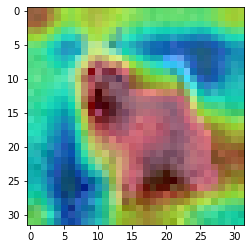

In [11]:
from pytorch_utils import gradcam, preprocess
import cv2

grad_cam = gradcam.GradCam(model=net, feature_module=net.layer3, \
                    target_layer_names=["1"], use_cuda=True)
img = cv2.imread("Dog.jpeg", 1)
img = np.float32(cv2.resize(img, (32, 32))) / 255
input = preprocess.preprocess_cifar10_image(img)
# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None
mask = grad_cam(input, target_index)
gradcam.show_cam_on_image(img, mask)